In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
#Initial Engine connection database (DataProvider and Connection String)
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#List column names in ORM Object
print("Measurement",[col for col in dir(Measurement) if not col.startswith('_')])
print("Station",[col for col in dir(Station) if not col.startswith('_')])

Measurement ['classes', 'date', 'id', 'metadata', 'prcp', 'prepare', 'station', 'tobs']
Station ['classes', 'elevation', 'id', 'latitude', 'longitude', 'metadata', 'name', 'prepare', 'station']


# Exploratory Climate Analysis

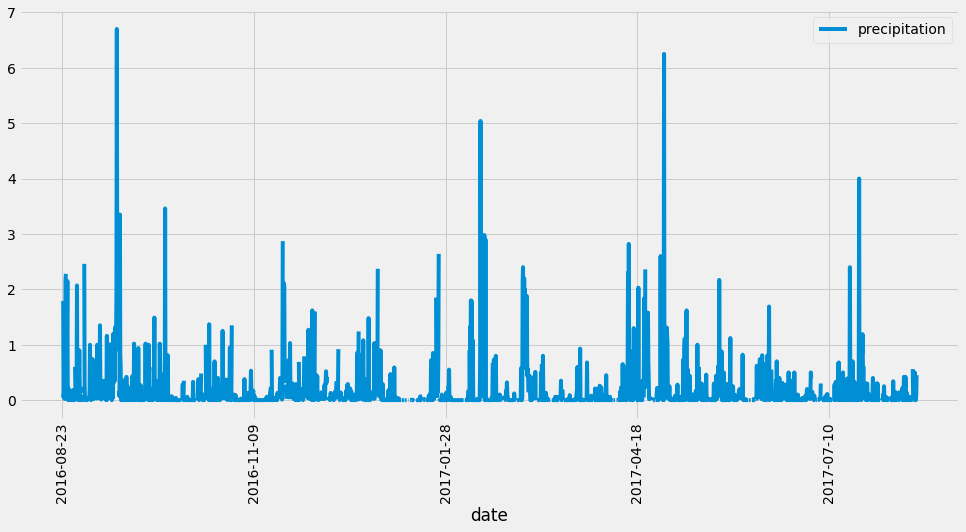

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 
prev_year = dt.date(2017, 8, 23)
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp)
query_filter = query.filter(Measurement.date >= prev_year)
results = query_filter.all()
#print(results)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index("date", inplace=True) 
# Sort the dataframe by date
df = df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(15,7),rot=90)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


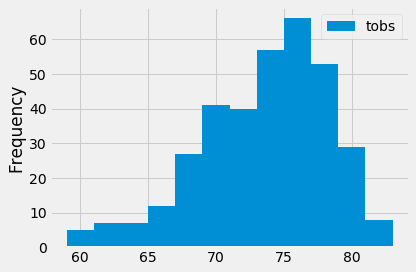

In [17]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
df.plot.hist(bins=12)
plt.tight_layout()

# Challenge

In [18]:
# find the min and max date of the data that we will analyze
max_min_Dates = session.query(func.min(Measurement.date),func.max(Measurement.date)).all()
max_min_Dates

[('2010-01-01', '2017-08-23')]

In [19]:
#Query the data from the SQLite DB 
#columns: date, station, precipitation, temperatures, month_year, month
#month_year and month to make groupby easier while analyze data
queryData = session.query(Measurement.date,Measurement.station,Measurement.prcp,Measurement.tobs, func.strftime("%m-%Y",Measurement.date), func.strftime("%m",Measurement.date) ).all()
columnNames = ["date","station","precipitation","temperatures","month_year","month"]
#load data into pandas dataframe to analyze
measurement_df = pd.DataFrame(queryData, columns = columnNames)
measurement_df

,date,station,precipitation,temperatures,month_year,month
0,2010-01-01,USC00519397,0.08,65.0,01-2010,01
1,2010-01-02,USC00519397,0.00,63.0,01-2010,01
2,2010-01-03,USC00519397,0.00,74.0,01-2010,01
3,2010-01-04,USC00519397,0.00,76.0,01-2010,01
4,2010-01-06,USC00519397,NaN,73.0,01-2010,01
...,...,...,...,...,...,...
19545,2017-08-19,USC00516128,0.09,71.0,08-2017,08
19546,2017-08-20,USC00516128,NaN,78.0,08-2017,08
19547,2017-08-21,USC00516128,0.56,76.0,08-2017,08
19548,2017-08-22,USC00516128,0.50,76.0,08-2017,08


### Statistics of "precipitation" and "temperatures" data  in June across all of the stations and years

In [20]:
#get the dataframe with "precipitation" and "temperatures" data for June
June_df = measurement_df[measurement_df["month"] == "06"][["precipitation","temperatures"]]
#use the built-in statistic function of pandas 
June_df.describe()

,precipitation,temperatures
count,1574.000000,1700.000000
mean,0.136360,74.944118
std,0.335731,3.257417
min,0.000000,64.000000
25%,0.000000,73.000000
50%,0.020000,75.000000
75%,0.120000,77.000000
max,4.430000,85.000000


1. In June, the precipitation is between 0 and 4.40. The number of measurements are 50% less than 0.02 while the average (mean) and standard deviation of measurements are respectly 0.1363 and 0.3357. This tells us the data of June precipitation measurements has many outliers. 
2. In June, the temperatures is between 64 and 85. The number of measurements are 50% less than 75. The average (mean) is 74.9 and the standard deviation is 3.25. This tells us the data of temperature measurements are stable and consistent.

### Statistics of "precipitation" and "temperatures" data  in December across all of the stations and years

In [21]:
#get the dataframe with "precipitation" and "temperatures" data for June
Dec_df = measurement_df[measurement_df["month"] == "12"][["precipitation","temperatures"]]
#use the built-in statistic function of pandas 
Dec_df.describe()

,precipitation,temperatures
count,1405.000000,1517.000000
mean,0.216819,71.041529
std,0.541399,3.745920
min,0.000000,56.000000
25%,0.000000,69.000000
50%,0.030000,71.000000
75%,0.150000,74.000000
max,6.420000,83.000000


1. In December, the precipitation is between 0 and 6.42. The number of measurements are 50% less than 0.03 while the average (mean) and standard deviation of measurements are respectly 0.2168 and 0.541. This tells us the data of December precipitation measurements also has many outliers. 
2. In June, the temperatures is between 56 and 83. The number of measurements are 50% less than 71. The average (mean) is 71.04 and the standard deviation is 3.745. This tells us the data of temperature measurements are stable and consistent.

### Statistics of "precipitation" data in June vs December across all of the stations and years

In [22]:
def printOutliers(data_series, name):
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3-Q1
    outlier_upper = Q3 + 1.5*(IQR)
    outlier_lower = Q1 - 1.5*(IQR)
    outlier_list = [x for x in list(data_series) if x > outlier_upper or x < outlier_lower ]
    print(f"[{outlier_lower:.2f} to {outlier_upper:.2}] Data range. Total {name} of outliers {len(outlier_list)} on total data {len(data_series)} or {len(outlier_list)*100/len(data_series):.2f}%")

      precipitation                                                
              count      mean       std  min  25%   50%   75%   max
month                                                              
06           1574.0  0.136360  0.335731  0.0  0.0  0.02  0.12  4.43
12           1405.0  0.216819  0.541399  0.0  0.0  0.03  0.15  6.42


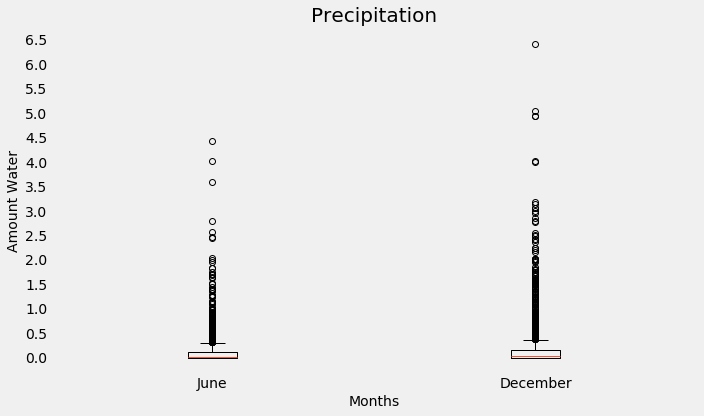

[-0.18 to 0.3] Data range. Total JUNE of outliers 183 on total data 1574 or 11.63%
[-0.22 to 0.38] Data range. Total DECEMBER of outliers 205 on total data 1405 or 14.59%


In [23]:
# Let get the dataframe of June and December precipitation 
Jun_Dec_Prcp_df = measurement_df[(measurement_df["month"] == "06") | (measurement_df["month"] == "12") ][["month","precipitation"]]
# group data by month
Jun_Dec_Prcp_df = Jun_Dec_Prcp_df.groupby("month")
# statictis
print(Jun_Dec_Prcp_df.describe())

# box-and-whisker plots to find outliers

# get series data of June and December and drop nan values
june_prcp_ser =measurement_df[(measurement_df["month"] == "06")]["precipitation"].dropna()
dec_prcp_ser = measurement_df[(measurement_df["month"] == "12")]["precipitation"].dropna()

# Plot on the same graph.
#set data
data = [june_prcp_ser, dec_prcp_ser]
#set labels
x_labels = ["June", "December"]
#format and plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Precipitation',fontsize=20)
ax.set_ylabel('Amount Water',fontsize=14)
ax.set_xlabel("Months",fontsize=14)
ax.boxplot(data, labels=x_labels)
ax.set_yticks(np.arange(0, 7, step=.5))
ax.grid()
plt.tight_layout()
plt.show()

#Find outliers
#JUNE
printOutliers(june_prcp_ser,"JUNE")
#DECEMBER
printOutliers(dec_prcp_ser,"DECEMBER")

1. The precipitation of Both December and June are relative low. June measurements are 50% lower than 0.03 and 75% lower than 0.15 while December measurements are 50% lower than 0.03 and 75% lower than 0.15. Therefore, December and June months are dry even thought the precipitation of December is litte higher than June. 
2. The number of outliers are very interesting for both June and December. There are 183 measurements of June or 11.63% outliers and 205 measurements of December or 14.59% outliers. These numbers tell that the precipition of days can be happened very suprised and it can wet days or very wet days. And December rains are more frequent suprised than June
3. The outliers of June are in the range (0.3 to 2.0) and December are in range (0.38 - 3.5). The precipition max of December is 6.42 versus 4.43 of June. Therefore, December has heavier rains then June. 

### Statistics of "temperatures" data in June vs December across all of the stations and years

      temperatures                                                   
             count       mean       std   min   25%   50%   75%   max
month                                                                
06          1700.0  74.944118  3.257417  64.0  73.0  75.0  77.0  85.0
12          1517.0  71.041529  3.745920  56.0  69.0  71.0  74.0  83.0


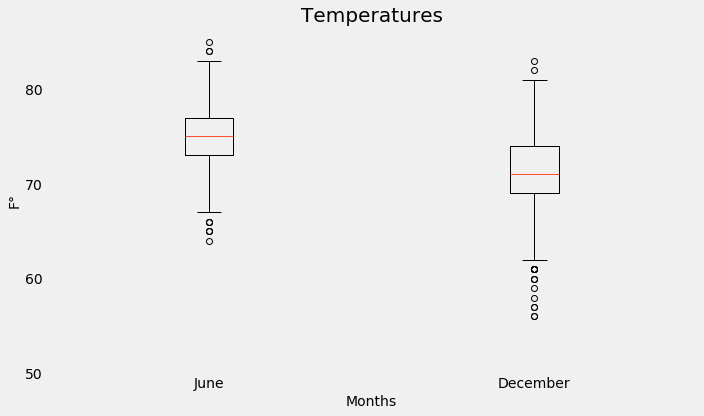

[67.00 to 8.3e+01] Data range. Total JUNE of outliers 10 on total data 1700 or 0.59%
[61.50 to 8.2e+01] Data range. Total DECEMBER of outliers 17 on total data 1517 or 1.12%


In [24]:
# Let get the dataframe of June and December temperatures 
Jun_Dec_Tobs_df = measurement_df[(measurement_df["month"] == "06") | (measurement_df["month"] == "12") ][["month","temperatures"]]
# group data by month
Jun_Dec_Tobs_df = Jun_Dec_Tobs_df.groupby("month")
# statictis
print(Jun_Dec_Tobs_df.describe())

# box-and-whisker plots to find outliers
# get series data of June and December and drop nan values
june_tobs_ser =measurement_df[(measurement_df["month"] == "06")]["temperatures"].dropna()
dec_tobs_ser = measurement_df[(measurement_df["month"] == "12")]["temperatures"].dropna()

# Plot on the same graph.
#set data
data = [june_tobs_ser, dec_tobs_ser]
#set labes
x_labels = ["June", "December"]
#format and plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Temperatures',fontsize=20)
ax.set_ylabel('F°',fontsize=14)
ax.set_xlabel("Months",fontsize=14)
ax.boxplot(data, labels=x_labels)
ax.set_yticks(np.arange(50, 90, step=10))
ax.grid()

plt.tight_layout()
plt.show()

#Find outliers
#JUNE
printOutliers(june_tobs_ser,"JUNE")
#DECEMBER
printOutliers(dec_tobs_ser,"DECEMBER")

1. The temperature of both December and June are relative mid 70. June measurements are 50% lower than 75 and 75% lower than 77 while December measurements are 50% lower than 71 and 75% lower than 74. Therefore, December and June months are mild temperature even thought the temperature of December is litte lower than June. 
2. The number of outliers are very low for both June and December. There are 10 measurements of June or 0.59% outliers and 17 measurements of December or 1.12% outliers. The temprature of both months are very consistent. 
3. The outliers of June are distributed evenly on the end while the outliers of December are distributed more below. Therefore, the tempratures of December can be a little suprised chiller than normal.

In [25]:
## Further analysis on the data between June data vs December data

Max Avg: 77.22 and Min Avg: 73.94


Text(0, 0.5, 'F°')

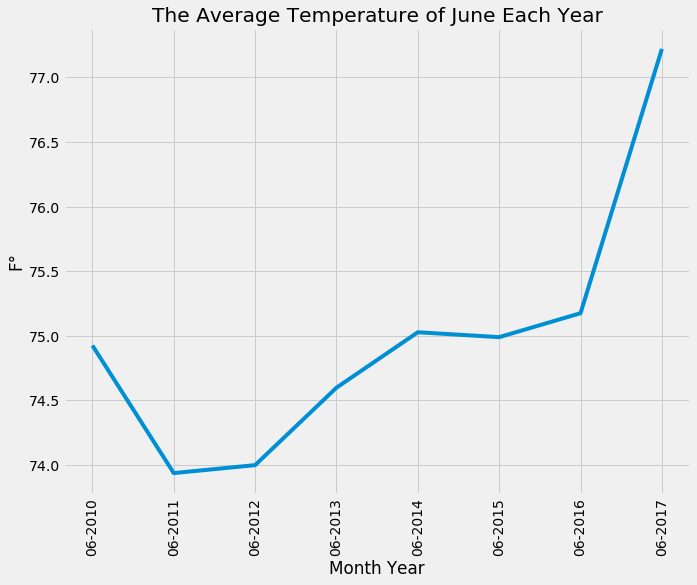

In [26]:
# The Average Temperature of June Each Year
temp_avg_month_df = measurement_df[measurement_df["month"]=="06"].groupby("month_year")["temperatures"].mean()
print(f"Max Avg: {temp_avg_month_df.max():.2f} and Min Avg: {temp_avg_month_df.min():.2f}")
ax = temp_avg_month_df.plot(figsize=(10,8),rot=90, title="The Average Temperature of June Each Year")
ax.set_xlabel("Month Year")
ax.set_ylabel("F°")

1. The maximum average temperature of June month was June 2017. It was a litte above 77.22.
2. The minimum average temperature of June month was June 2014. It was a litte below 74.94.

Max Avg: 73.42 and Min Avg: 69.90


Text(0, 0.5, 'F°')

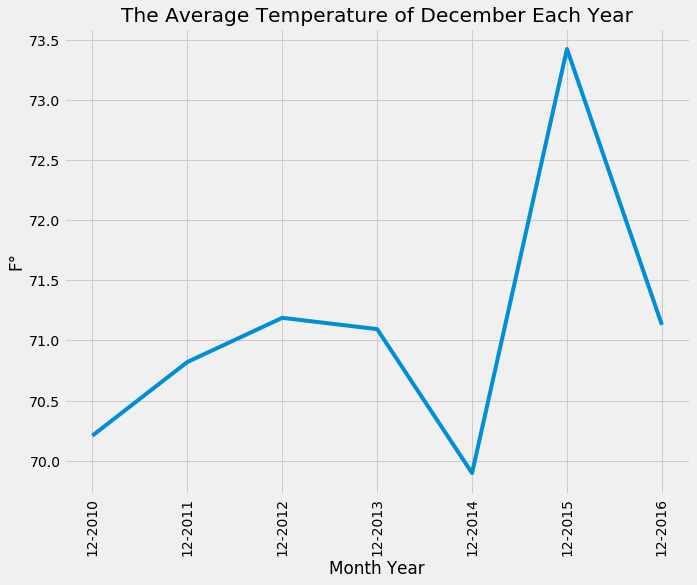

In [27]:
# The Average Temperature of December Each Year
temp_avg_month_df = measurement_df[measurement_df["month"]=="12"].groupby("month_year")["temperatures"].mean()
print(f"Max Avg: {temp_avg_month_df.max():.2f} and Min Avg: {temp_avg_month_df.min():.2f}")
ax = temp_avg_month_df.plot(figsize=(10,8),rot=90, title="The Average Temperature of December Each Year")
ax.set_xlabel("Month Year")
ax.set_ylabel("F°")

1. The maximum average temperature of December month was June 2015. It was about 73.42.
2. The minimum average temperature of December month was June 2014. It was about 79.9.

Max Avg: 0.24 and Min Avg: 0.04


Text(0, 0.5, 'Amount Water')

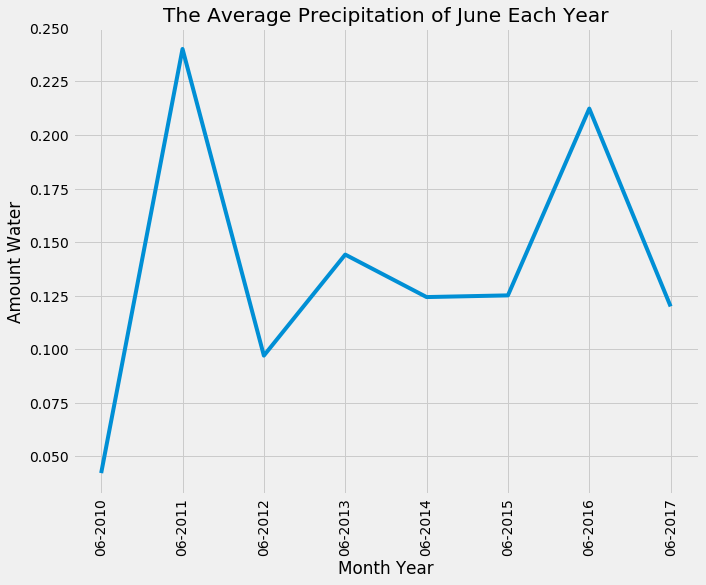

In [28]:
# The precipitation Temperature of June Each Year
prcp_avg_month_df = measurement_df[measurement_df["month"]=="06"].groupby("month_year")["precipitation"].mean()
print(f"Max Avg: {prcp_avg_month_df.max():.2f} and Min Avg: {prcp_avg_month_df.min():.2f}")
ax = prcp_avg_month_df.plot(figsize=(10,8),rot=90, title="The Average Precipitation of June Each Year")
ax.set_xlabel("Month Year")
ax.set_ylabel("Amount Water")

1. The maximum average precipitation of June month was June 2011. It was about 0.24.
2. The minimum average precipitation of June month was June 2010. It was about 0.04.

Max Avg: 0.46 and Min Avg: 0.09


Text(0, 0.5, 'Amount Water')

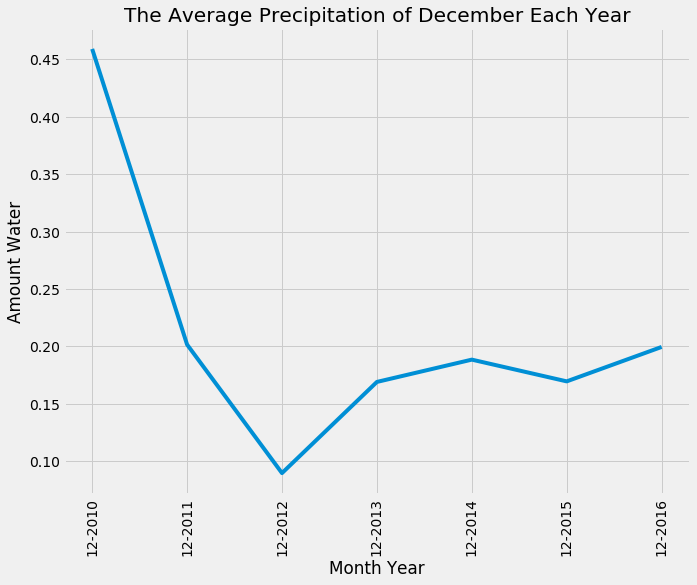

In [29]:
# The precipitation Temperature of December Each Year
prcp_avg_month_df = measurement_df[measurement_df["month"]=="12"].groupby("month_year")["precipitation"].mean()
print(f"Max Avg: {prcp_avg_month_df.max():.2f} and Min Avg: {prcp_avg_month_df.min():.2f}")
ax = prcp_avg_month_df.plot(figsize=(10,8),rot=90, title="The Average Precipitation of December Each Year")
ax.set_xlabel("Month Year")
ax.set_ylabel("Amount Water")

1. The maximum average precipitation of June month was June 2011. It was about 0.46.
2. The minimum average precipitation of June month was June 2010. It was about 0.09.

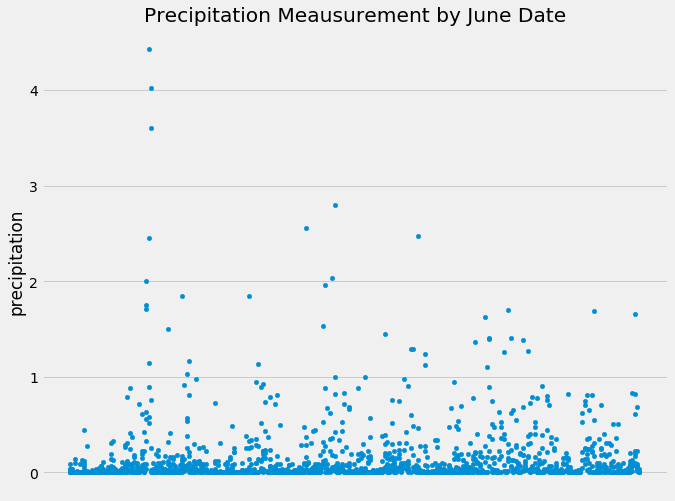

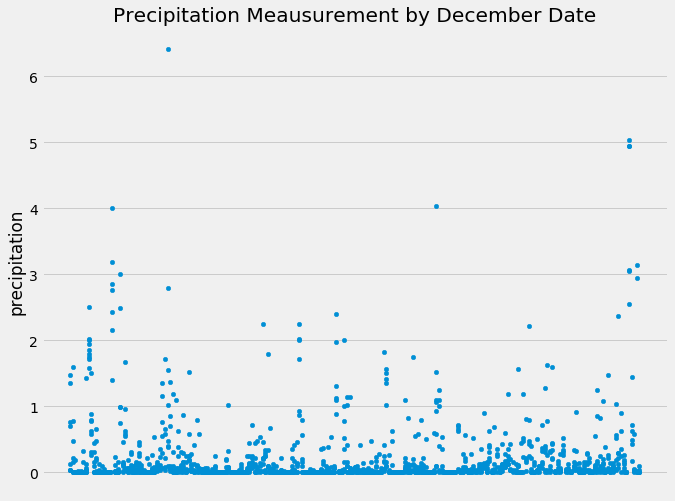

In [30]:
# scatter plot Precipitation Meausurement by June Date
prcp_avg_month_df = measurement_df[measurement_df["month"]=="06"][["date","precipitation"]]
ax = prcp_avg_month_df.plot(x="date",y="precipitation",kind="scatter",figsize = (10,8),title="Precipitation Meausurement by June Date")
ax.get_xaxis().set_visible(False)
# scatter plot Precipitation Meausurement by December Date
prcp_avg_month_df = measurement_df[measurement_df["month"]=="12"][["date","precipitation"]]
ax = prcp_avg_month_df.plot(x="date",y="precipitation",kind="scatter",figsize = (10,8),title="Precipitation Meausurement by December Date")
ax.get_xaxis().set_visible(False)

In [31]:
## Further analysis on the data between June data to December data

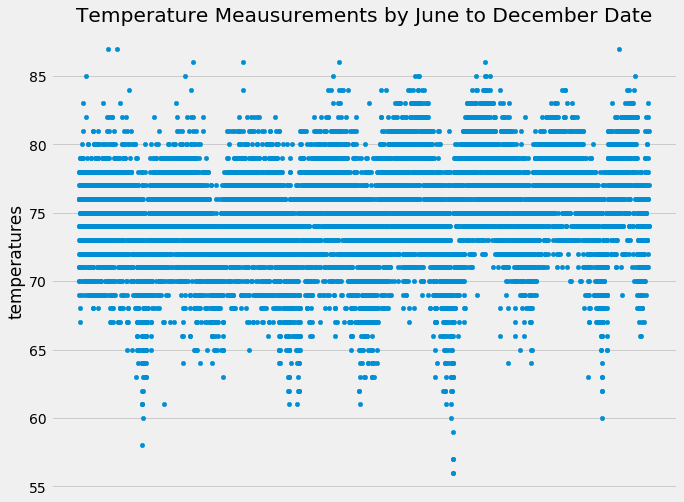

In [32]:
# scatter plot Precipitation Meausurement between June data to December data
temp_avg_month_df = measurement_df[measurement_df["month"].isin(["06","07","08","09","10","11","12"])][["date","temperatures"]]
ax = temp_avg_month_df.plot(x="date",y="temperatures",kind="scatter",figsize = (10,8),title="Temperature Meausurements by June to December Date")
ax.get_xaxis().set_visible(False)

The most of temperature measurements are between 68 to 80 between June and December

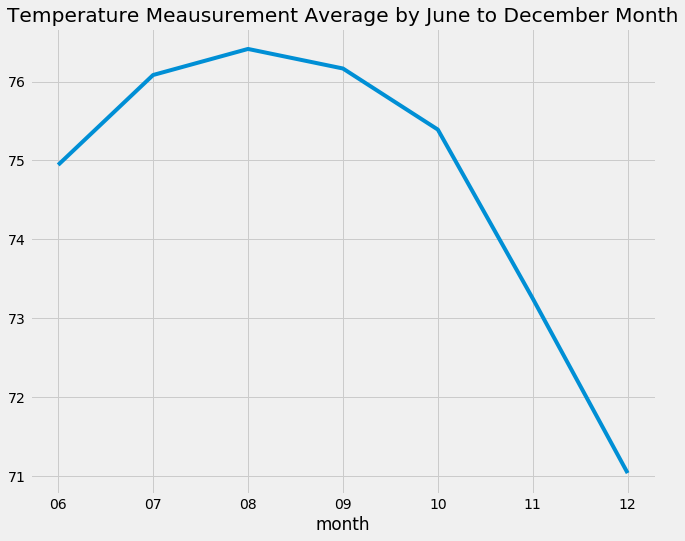

In [33]:
temp_avg_month_df = measurement_df[measurement_df["month"].isin(["06","07","08","09","10","11","12"])].groupby("month")["temperatures"].mean()

ax = temp_avg_month_df.plot(figsize = (10,8),title="Temperature Meausurement Average by June to December Month")
#ax.get_xaxis().set_visible(False)

1. The temperature averages are rise between June and August.
2. The temperature averages are cold down from August to December. 
3. The temperature averages are different about 5.5 between August and December

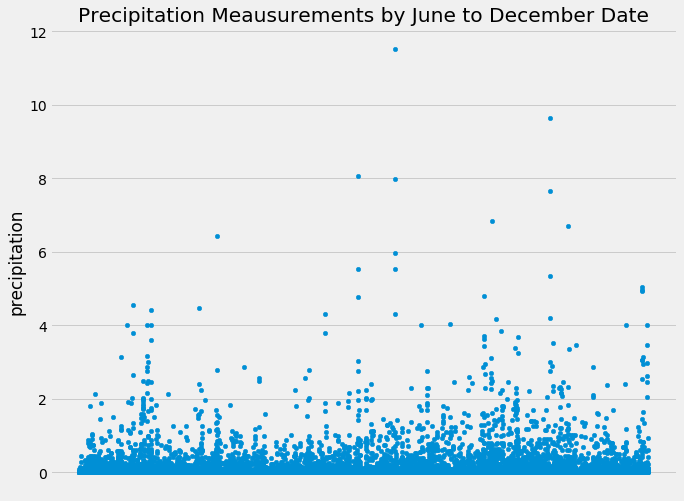

In [34]:
# scatter plot Precipitation Meausurement by June Date
prcp_avg_month_df = measurement_df[measurement_df["month"].isin(["06","07","08","09","10","11","12"])][["date","precipitation"]]
ax = prcp_avg_month_df.plot(x="date",y="precipitation",kind="scatter",figsize = (10,8),title="Precipitation Meausurements by June to December Date")
ax.get_xaxis().set_visible(False)

The most of Precipitation measurements are between 0.0 to 1.0 between June and December

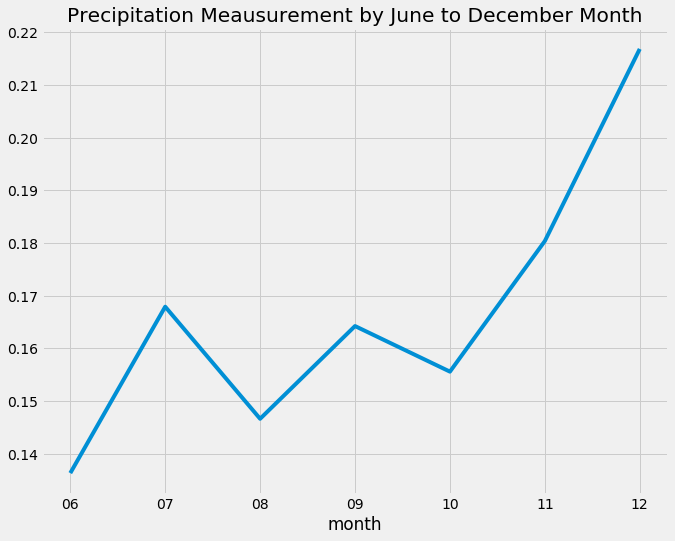

In [35]:
prcp_avg_month_df = measurement_df[measurement_df["month"].isin(["06","07","08","09","10","11","12"])].groupby("month")["precipitation"].mean()

ax = prcp_avg_month_df.plot(figsize = (10,8),title="Precipitation Meausurement by June to December Month")
#ax.get_xaxis().set_visible(False)

1. The Precipitation averages are rise between October and December.
2. The Precipitation averages are dry between June and October. 
3. The Precipitation averages are different about 0.9 between June and December